# BodyFat dataset

Comparison of different inducing point GP-regression methods.

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_regression import GPR

from sklearn.cluster import KMeans

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.svm import SVR
from sklearn.metrics import r2_score
%matplotlib inline
%load_ext autoreload
%autoreload 2

Loading the data

In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Regression/bodyfat(252, 14).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
data_name = 'bodyfat'
file_name = data_name

x_tr = x_tr.toarray().T
scaler_x = StandardScaler()
scaler_y = StandardScaler()

y_tr = y_tr.reshape((y_tr.size, 1))
x_test = x_tr[:, int(x_tr.shape[1] * 0.8):]
y_test = y_tr[int(x_tr.shape[1] * 0.8):, :]
y_tr = y_tr[:int(x_tr.shape[1] * 0.8), :]
x_tr = x_tr[:, : int(x_tr.shape[1] * 0.8)]

print(x_tr.shape)
print(x_test.shape)

x_tr = scaler_x.fit_transform(x_tr.T).T
x_test = scaler_x.transform(x_test.T).T
y_tr = scaler_y.fit_transform(y_tr)
y_test = scaler_y.transform(y_test)


dim, num = x_tr.shape
print('of objects:', num)
print('of features', dim)
print(data_name)

(14, 201)
(14, 51)
of objects: 201
of features 14
bodyfat


## SVM
We train an SVM with RBF kernel for reference.

In [3]:
svm = SVR(C=1e1)
svm.fit(x_tr.T, y_tr[:, 0])
pred = svm.predict(x_test.T)
r2_score(y_test, pred)

0.91143295812258962

# K-means cluster centers as inducing inputs

We use K-means cluster centers as inducing point positions and don't optimize wrt them.

In [4]:
ind_num = 20
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [5]:
cov_params = np.array([1., 2., 1.])

In [6]:
default_plot_interval = [0.55, 1.05]
def plot_results(it_lst, t_lst, y_lst, clr, label, plot_interval=None):
    if plot_interval is None:
        plot_interval = default_plot_interval
    plt.figure(figsize=(13,5))

    plt.subplot(1, 2, 1)
    plt.plot(it_lst, y_lst, clr, label=label)
    plt.ylim(plot_interval)
    plt.legend(loc=4)
    plt.xlabel('Iterations')
    plt.ylabel('r2 score on test-set')

    plt.subplot(1, 2, 2)
    plt.plot(t_lst, y_lst, clr, label=label)
    plt.ylim(plot_interval)
    plt.legend(loc=4)
    plt.xlabel('Time(s)')
    plt.ylabel('r2 score on test-set')

# SVI-L-BFGS-B

L-BFGS-B optimization method applied to the svi objective (see the text).

In [9]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
lbfgs_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='L-BFGS-B')

In [10]:
opts = {'maxiter': 50, 'mydisp': False}
lbfgs_svi_res = lbfgs_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

In [23]:
metric = lambda w: lbfgs_svi_gp.get_prediction_quality(w, x_test, y_test)
lbfgs_svi_xi_lst, lbfgs_svi_xt_lst, lbfgs_svi_y_lst = lbfgs_svi_res.plot_performance(metric, 'it', freq=1)

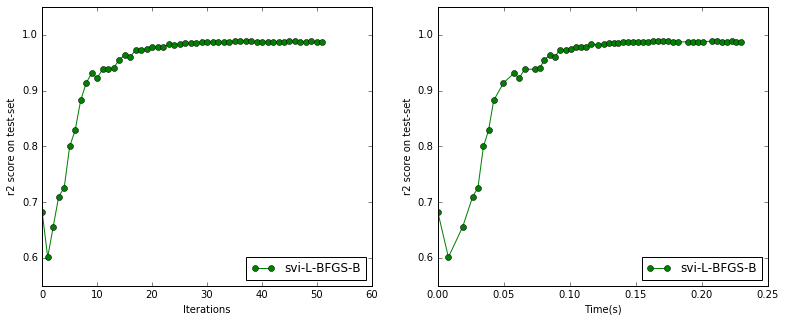

In [37]:
plot_results(lbfgs_svi_xi_lst, lbfgs_svi_xt_lst, lbfgs_svi_y_lst, '-go', 'svi-L-BFGS-B')

In [56]:
np.save('../plots/regression_revision/'+ data_name +'/' + data_name + '_lbfgs_svi_xi.npy', lbfgs_svi_xi_lst)
np.save('../plots/regression_revision/'+ data_name +'/' + data_name + '_lbfgs_svi_xt.npy', lbfgs_svi_xt_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_lbfgs_svi_y.npy', lbfgs_svi_y_lst)

## VI
L-BFGS-B optimization method applied to the vi objective (see the text).

In [57]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPR(model_covariance_obj, method='means', optimizer='L-BFGS-B')

In [32]:
opts = {'maxiter': 20, 'disp': True}
vi_res = vi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

In [40]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_xi_lst, vi_xt_lst, vi_y_lst = vi_res.plot_performance(metric, 'it', freq=1)

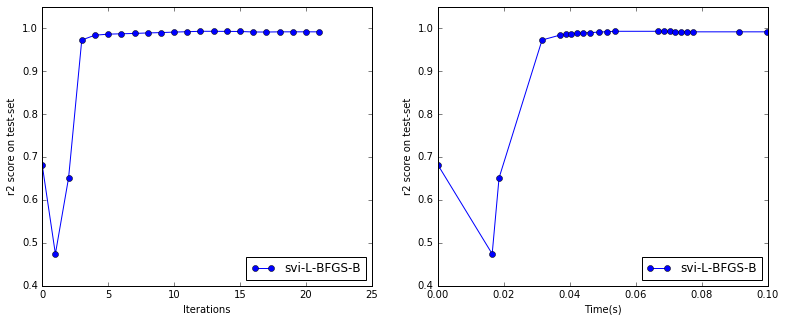

In [45]:
plot_results(vi_xi_lst, vi_xt_lst, vi_y_lst, '-bo', 'svi-L-BFGS-B', plot_interval=[0.4, 1.05])

In [46]:
vi_y_lst[-1]

0.99168317324470756

In [48]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_vi_xi.npy', vi_xi_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_vi_xt.npy', vi_xt_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_vi_y.npy', vi_y_lst)

## Stochastic SVI
Stochastic (incremental) optimization methods applied to the svi objective (see the text).
### AdaDelta-Cholesky
Adadelta method from climin library.

In [49]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='AdaDelta')

In [50]:
opts = {'mydisp': False, 'step_rate': .3,
                'maxiter': 500, 'batch_size':20}
ad_svi_res = ad_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

In [51]:
metric = lambda w: ad_svi_gp.get_prediction_quality(w, x_test, y_test)
ad_svi_xi_lst, ad_svi_xt_lst, ad_svi_y_lst = ad_svi_res.plot_performance(metric, 'it', freq=5)

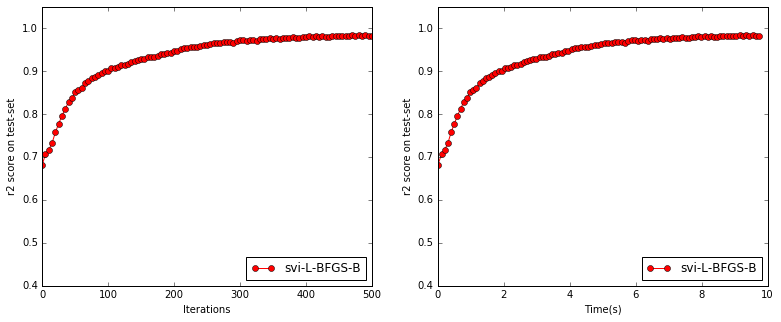

In [53]:
plot_results(ad_svi_xi_lst, ad_svi_xt_lst, ad_svi_y_lst, '-ro', 'svi-L-BFGS-B', plot_interval=[0.4, 1.05])

In [54]:
ad_svi_y_lst[-1]

0.98232235716422545

In [55]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_ad_svi_xi.npy', ad_svi_xi_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_ad_svi_xt.npy', ad_svi_xt_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_ad_svi_y.npy', ad_svi_y_lst)

###SG-cholesky
Stochastic gradient descent.

In [55]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
sg_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='SG')

In [56]:
opts = {'maxiter':1000, 'batch_size': 20 , 'print_freq': 50, 'step0': 1e-1, 'gamma': .3}
sg_svi_res = sg_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Epoch  0 :
	Step: 0.1
	Parameters [ 0.69256681  2.2043455 ]
Epoch  50 :
	Step: 0.0309249494711
	Parameters [ 0.72130494  3.91712538]
Epoch  100 :
	Step: 0.0251188643151
	Parameters [ 0.78754291  4.71027964]
Epoch  150 :
	Step: 0.0222419378195
	Parameters [ 0.87738742  5.29353367]
Epoch  200 :
	Step: 0.0204028577337
	Parameters [ 0.9350254   5.79530644]
Epoch  250 :
	Step: 0.0190817410266
	Parameters [ 0.95513656  6.23494103]
Epoch  300 :
	Step: 0.0180660672935
	Parameters [ 1.12886031  6.62706835]
Epoch  350 :
	Step: 0.017249622163
	Parameters [ 1.13474621  7.00406712]
Epoch  400 :
	Step: 0.0165722700867
	Parameters [ 1.19795364  7.34232512]
Epoch  450 :
	Step: 0.0159969153201
	Parameters [ 1.22622258  7.66945759]
Epoch  500 :
	Step: 0.0154991898755
	Parameters [ 1.30674267  7.96071809]
Epoch  550 :
	Step: 0.0150622965261
	Parameters [ 1.30557159  8.23217284]
Epoch  600 :
	Step: 0.0146742064519
	Parameters [ 1.40157123  8.48062909]
Epoch  650 :
	Step: 0.0143260345104
	Parameters [ 1.46

In [57]:
metric = lambda w: sg_svi_gp.get_prediction_quality(w, x_test, y_test)
sg_svi_x_lst, sg_svi_y_lst = sg_svi_res.plot_performance(metric, 'i', freq=5)

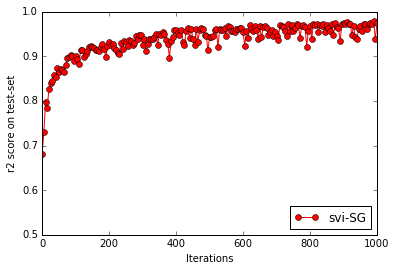

In [58]:
plt.plot(sg_svi_x_lst, sg_svi_y_lst, '-ro', label='svi-SG')
plt.ylim([.5, 1.])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [59]:
sg_svi_y_lst[-1]

0.9740962028055451

In [88]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_sg_svi_x.npy', sg_svi_x_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_sg_svi_y.npy', sg_svi_y_lst)

### SG-Natural
Stochastic gradient descent with natural gradients with respect to the variational parameters.

In [95]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
sng_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='natural')

In [96]:
opts = {'maxiter':2000, 'batch_size': 20 , 'print_freq': 50, 'step0': 3e-1, 'gamma': 0.35}
sng_svi_res = sng_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Epoch  0 :
	Step: 0.3
	Parameters [ 0.59694578  2.50742146]
Epoch  50 :
	Step: 0.076292483635
	Parameters [ 0.86145318  5.0001317 ]
Epoch  100 :
	Step: 0.0598578694491
	Parameters [ 0.93007149  5.92240776]
Epoch  150 :
	Step: 0.0519384893724
	Parameters [ 1.0382226   6.55841184]
Epoch  200 :
	Step: 0.0469635325037
	Parameters [ 1.12625326  7.05980598]
Epoch  250 :
	Step: 0.0434352426152
	Parameters [ 1.20521289  7.51193233]
Epoch  300 :
	Step: 0.0407501128304
	Parameters [ 1.182371    7.92772676]
Epoch  350 :
	Step: 0.0386097899742
	Parameters [ 1.20486512  8.26975818]
Epoch  400 :
	Step: 0.0368468407835
	Parameters [ 1.30941162  8.57636233]
Epoch  450 :
	Step: 0.0353587476742
	Parameters [ 1.28286552  8.87660174]
Epoch  500 :
	Step: 0.0340786006442
	Parameters [ 1.33842547  9.1393175 ]
Epoch  550 :
	Step: 0.0329605396333
	Parameters [ 1.41408484  9.39610688]
Epoch  600 :
	Step: 0.0319718905142
	Parameters [ 1.47996087  9.62973508]
Epoch  650 :
	Step: 0.0310886296941
	Parameters [ 1.47

In [97]:
metric = lambda w: sng_svi_gp.get_prediction_quality(w, x_test, y_test)
sng_svi_x_lst, sng_svi_y_lst = sng_svi_res.plot_performance(metric, 'i', freq=10)

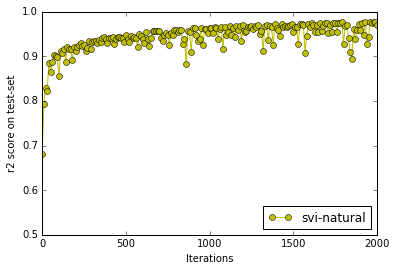

In [98]:
plt.plot(sng_svi_x_lst, sng_svi_y_lst, '-yo', label='svi-natural')
plt.ylim([.5, 1.])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [99]:
sng_svi_y_lst[-1]

0.97056416469530171

In [100]:
np.max(sng_svi_y_lst)

0.9774048298027832

In [101]:
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_sng_svi_x.npy', sng_svi_x_lst)
np.save('../plots/regression_revision/' + data_name +'/' + data_name + '_sng_svi_y.npy', sng_svi_y_lst)

## SVI-SAG

In [29]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
sag_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='SAG')

In [30]:
opts = {'maxiter':2000, 'batch_size': 20 , 'print_freq': 100}
sag_svi_res = sag_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Epoch  0 :
	Lipschitz constant estimate: 8.52032871552
	 [ 0.46545365  2.33398699]
Epoch  100 :
	Lipschitz constant estimate: 34.0813148621
	 [ 0.88705904  5.28620967]
Epoch  200 :
	Lipschitz constant estimate: 34.0813148621
	 [ 1.04806524  6.3106858 ]
Epoch  300 :
	Lipschitz constant estimate: 34.0813148621
	 [ 1.18205514  7.09781052]
Epoch  400 :
	Lipschitz constant estimate: 34.0813148621
	 [ 1.28098366  7.71565381]
Epoch  500 :
	Lipschitz constant estimate: 34.0813148621
	 [ 1.36963628  8.21155512]
Epoch  600 :
	Lipschitz constant estimate: 68.1626297241
	 [ 1.43838497  8.61822394]
Epoch  700 :
	Lipschitz constant estimate: 68.1626297241
	 [ 1.50625057  8.96971241]
Epoch  800 :
	Lipschitz constant estimate: 68.1626297241
	 [ 1.56784667  9.29644332]
Epoch  900 :
	Lipschitz constant estimate: 68.1626297241
	 [ 1.62506384  9.60161541]
Epoch  1000 :
	Lipschitz constant estimate: 68.1626297241
	 [ 1.67880412  9.88802723]
Epoch  1100 :
	Lipschitz constant estimate: 68.1626297241
	 [  1.7

In [31]:
metric = lambda w: sag_svi_gp.get_prediction_quality(w, x_test, y_test)
sag_svi_xi_lst, sag_svi_xt_lst, sag_svi_y_lst = sag_svi_res.plot_performance(metric, 'it', freq=10)

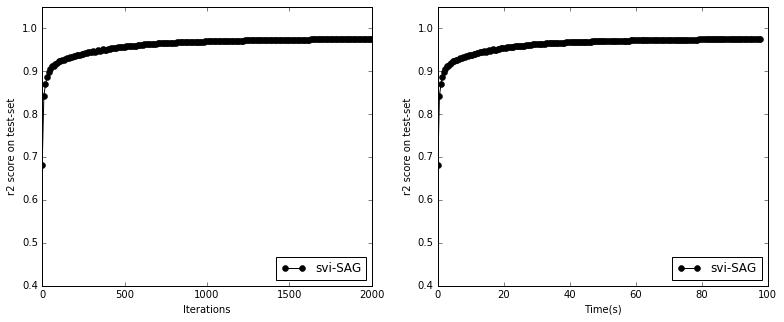

In [32]:
plot_results(sag_svi_xi_lst, sag_svi_xt_lst, sag_svi_y_lst, '-ko', 'svi-SAG', plot_interval=[0.4, 1.05])